In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import lime


from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [3]:
correlations = X_scaled.corrwith(pd.Series(y)).abs()
selected_features = correlations[correlations >= 0.5].index.tolist()
X_selected = X_scaled[selected_features]
print(f"Number of selected features: {len(selected_features)}")


Number of selected features: 15


For 80-20 split:
Accuracy: 96.491%
Precision (malignant): 95.238%
Recall (malignant): 95.238%
F1-score (malignant): 95.238%


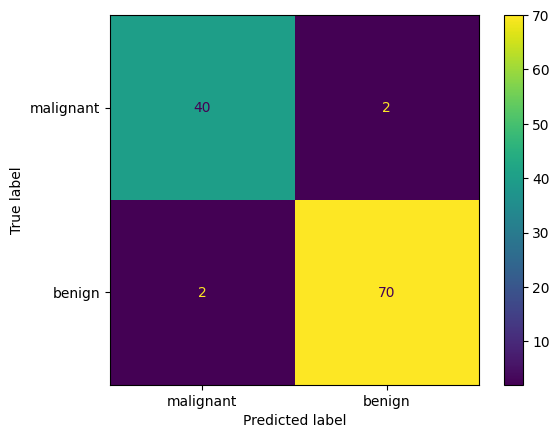

In [4]:
model = LogisticRegression(solver='liblinear', max_iter=300)

# 80-20 split, train, and evaluate
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("For 80-20 split:")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.3f}%")
print(f"Precision (malignant): {precision_score(y_test, y_pred, pos_label=0) * 100:.3f}%")
print(f"Recall (malignant): {recall_score(y_test, y_pred, pos_label=0) * 100:.3f}%")
print(f"F1-score (malignant): {f1_score(y_test, y_pred, pos_label=0) * 100:.3f}%")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot()
plt.show()

For 70-30 split:
Accuracy: 93.567%
Precision (malignant): 93.443%
Recall (malignant): 89.062%
F1-score (malignant): 91.200%


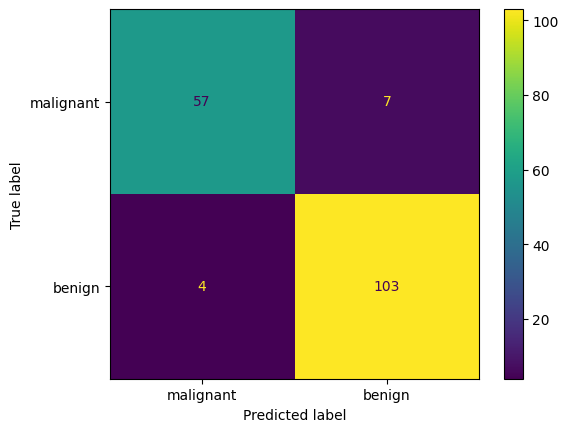

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("For 70-30 split:")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.3f}%")
print(f"Precision (malignant): {precision_score(y_test, y_pred, pos_label=0) * 100:.3f}%")
print(f"Recall (malignant): {recall_score(y_test, y_pred, pos_label=0) * 100:.3f}%")
print(f"F1-score (malignant): {f1_score(y_test, y_pred, pos_label=0) * 100:.3f}%")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot()
plt.show()


# The 80-20 split gave better results in terms of accuracy, precision, recall, and F1-score.

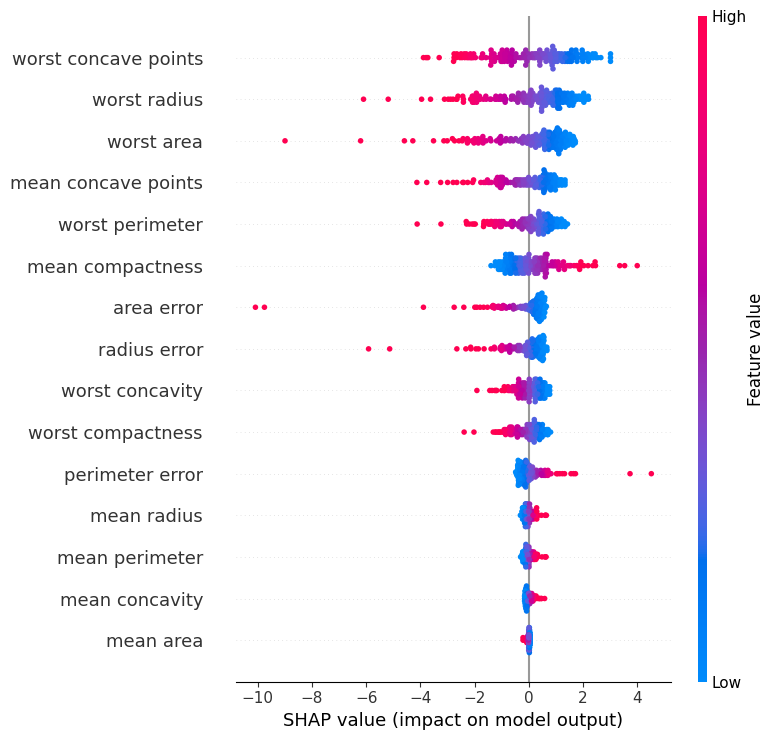

In [6]:
# SHAP
explainer_shap = shap.Explainer(model, X_train)
shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_selected.columns)

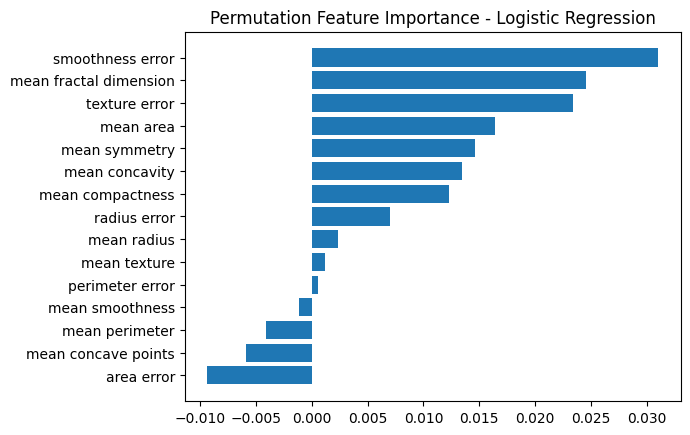

In [7]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - Logistic Regression")
plt.show()

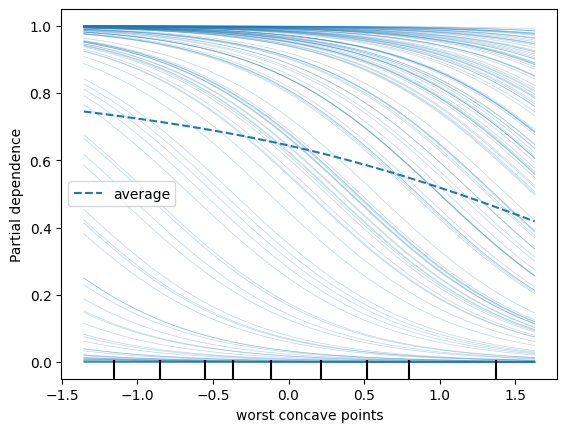

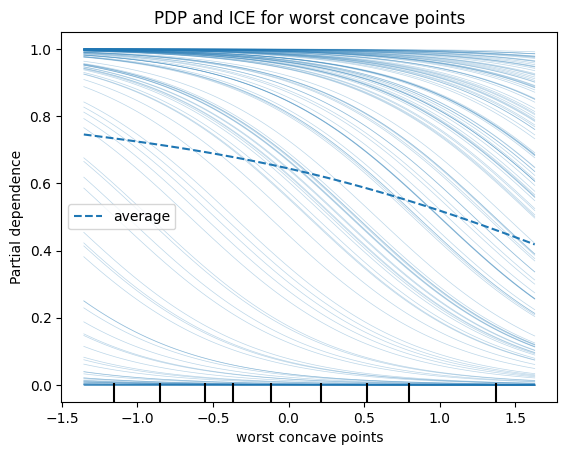

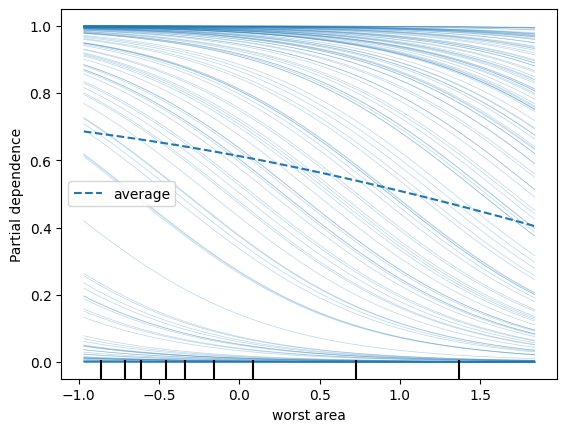

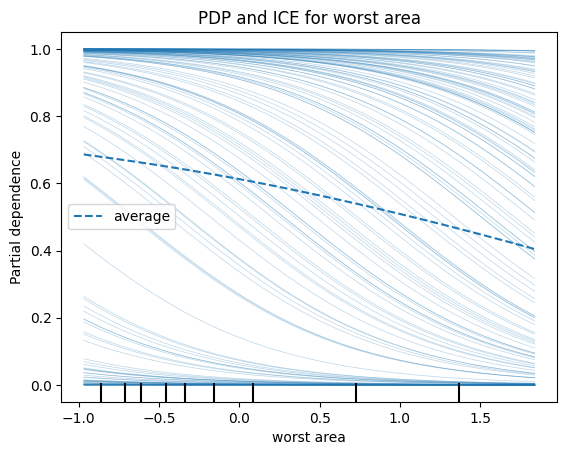

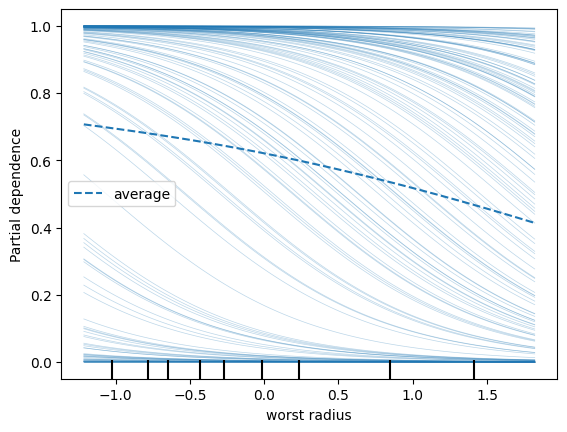

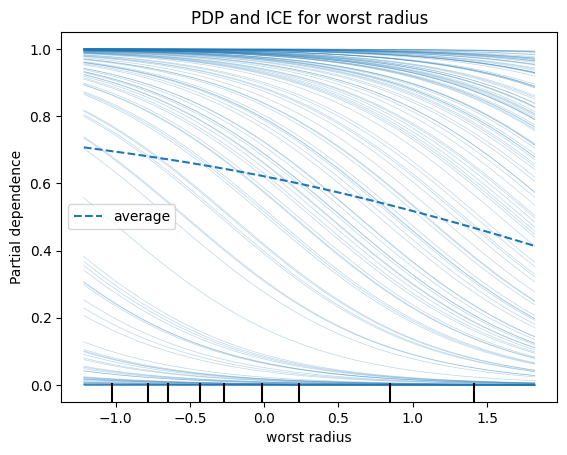

In [8]:

coefs = pd.Series(model.coef_[0], index=X_selected.columns).abs()
top_features = coefs.sort_values(ascending=False).head(3).index

# Partial Dependence Plots with ICE
for feature in top_features:
    display = PartialDependenceDisplay.from_estimator(model, X_test, [feature], target=y, kind='both')
    display.plot()
    plt.title(f"PDP and ICE for {feature}")
    plt.show()

In [9]:
lime=lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', training_labels=None, feature_names=data.feature_names, categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, verbose=False, class_names=data.target_names, feature_selection='auto', discretize_continuous=True, discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)

In [10]:
instance = lime.explain_instance(X_test.values[0], model.predict_proba, labels=(1,), top_labels=None, num_features=15, num_samples=5000, distance_metric='euclidean')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [11]:
instance.show_in_notebook(show_table=True)